In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup, Comment
import requests
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [17]:
url = 'https://www.basketball-reference.com/players/'

In [18]:
url_test = 'https://www.basketball-reference.com/players/a/'

In [19]:
soup = BeautifulSoup(requests.get(url_test).text, 'lxml')

In [20]:
url_test_player = 'https://www.basketball-reference.com/players/a/abdelal01.html'

In [21]:
soup1 = BeautifulSoup(requests.get(url_test_player).text, 'lxml')

In [22]:
#grab column headers
c1 = [col.text for col in soup.find('thead').find_all('th')]
c2 = list(map(lambda x: x+'_game', [col.text for col in soup1.find(attrs={'id': 'per_game'}).find('thead').find_all('th')]))
comment_txt = soup1.find(attrs={'id': 'all_per_minute'}).find(text=lambda text:isinstance(text, Comment))
subsoup1 = BeautifulSoup(comment_txt, 'lxml')
c3 = list(map(lambda x: x+'_min', [col.text for col in subsoup1.find(attrs={'id': 'per_minute'}).find('thead').find_all('th')]))
comment_txt = soup1.find(attrs={'id': 'all_per_poss'}).find(text=lambda text:isinstance(text, Comment))
subsoup1 = BeautifulSoup(comment_txt, 'lxml')
c4 = list(map(lambda x: x+'_poss', [col.text for col in subsoup1.find(attrs={'id': 'per_poss'}).find('thead').find_all('th')]))
comment_txt = soup1.find(attrs={'id': 'all_advanced'}).find(text=lambda text:isinstance(text, Comment))
subsoup1 = BeautifulSoup(comment_txt, 'lxml')
c5 = list(map(lambda x: x+'_adv', [col.text for col in subsoup1.find(attrs={'id': 'advanced'}).find('thead').find_all('th')]))

In [23]:
columns = c1 + list(map(lambda x: x+'_r', c2+c3+c4+c5)) + list(map(lambda x: x+'_c', c2+c3+c4+c5))

In [24]:
def getRookieData(soup, id_string):
    lst = []
    for col in soup.find(attrs={'id': id_string}).find(attrs={'class': 'full_table'}).contents:
        lst.append(col.text)
    return lst

In [25]:
def getCareerData(soup, id_string):
    lst = []
    for col in soup.find(attrs={'id': id_string}).find('tfoot').find('tr').contents:
        lst.append(col.text)
    return lst

In [26]:
def getCommentedTableData(soup, id_string):
    comment_txt = soup.find(attrs={'id': 'all_'+id_string}).find(text=lambda text:isinstance(text, Comment))
    subsoup = BeautifulSoup(comment_txt, 'lxml')
    return getRookieData(subsoup, id_string), getCareerData(subsoup, id_string)

In [27]:
def scrapePlayerPage(url):
    soup = BeautifulSoup(requests.get(url).text, 'lxml')
    per_game_rookie = getRookieData(soup, 'per_game')
    per_game_career = getCareerData(soup, 'per_game')
    per_minute_rookie, per_minute_career = getCommentedTableData(soup, 'per_minute')
    per_poss_rookie, per_poss_career = getCommentedTableData(soup, 'per_poss')
    advanced_rookie, advanced_career = getCommentedTableData(soup, 'advanced')
    out = per_game_rookie+per_minute_rookie+per_poss_rookie+advanced_rookie+ \
        per_game_career+per_minute_career+per_poss_career+advanced_career
    return out

In [77]:
avail_letters = 'abcdefghijklmnopqrstuvwyz'
'''
for letter in avail_letters:
    final_data = []
    sub_url = url + letter + '/'
    # loop through the page of names and store player data, and then process the link to each player's page
    soup = BeautifulSoup(requests.get(sub_url).text, 'lxml')
    for p in soup.find_all('th', attrs={'data-stat': 'player', 'scope': 'row'}):
        try:
            row = p.parent
            player = []
            for child in row.contents:
                player.append(child.text)
            name, year_start, year_end, position, height, weight, DOB, college = player
            player_url = 'https://www.basketball-reference.com' + row.find('a')['href']
            player += scrapePlayerPage(player_url)
            if len(player) != 248: #skip if player doesn't have all the columns
                continue
            player_dict = dict(zip(columns, player))
            final_data.append(player_dict)
        except:
            continue
    #save after every letter
    with open('bball_data_' + letter + '.pkl', 'wb') as picklefile: #make a file for every letter
        pickle.dump(pd.DataFrame(final_data), picklefile)
'''

"\nfor letter in avail_letters:\n    final_data = []\n    sub_url = url + letter + '/'\n    # loop through the page of names and store player data, and then process the link to each player's page\n    soup = BeautifulSoup(requests.get(sub_url).text, 'lxml')\n    for p in soup.find_all('th', attrs={'data-stat': 'player', 'scope': 'row'}):\n        try:\n            row = p.parent\n            player = []\n            for child in row.contents:\n                player.append(child.text)\n            name, year_start, year_end, position, height, weight, DOB, college = player\n            player_url = 'https://www.basketball-reference.com' + row.find('a')['href']\n            player += scrapePlayerPage(player_url)\n            if len(player) != 248: #skip if player doesn't have all the columns\n                continue\n            player_dict = dict(zip(columns, player))\n            final_data.append(player_dict)\n        except:\n            continue\n    #save after every letter\n    w

In [78]:
df_raw = pd.DataFrame()
for letter in avail_letters:
    with open('bball_data_' + letter + '.pkl', 'rb') as picklefile:
        data = pickle.load(picklefile)
    df_raw = pd.concat([df_raw, data])

In [79]:
df = df_raw.copy()

In [80]:
df['Player'] = df['Player'].apply(lambda x: x.strip('*'))
df = df.set_index('Player')

In [81]:
df = df.apply(lambda col: pd.to_numeric(col, errors='ignore')).dropna(axis=1, how='all')

In [82]:
nba = ((df.Lg_game_c == 'NBA') & (df.Lg_game_r == 'NBA') & (df.Lg_min_c == 'NBA') & (df.Lg_min_r == 'NBA') &
       (df.Lg_poss_c == 'NBA') & (df.Lg_poss_r == 'NBA') & (df.Lg_adv_c == 'NBA') & (df.Lg_adv_r == 'NBA'))
df = df[nba]

In [83]:
df = df.drop(columns = ['Lg_game_c', 'Lg_game_r', 'Lg_min_c', 'Lg_min_r',
                        'Lg_poss_c', 'Lg_poss_r', 'Lg_adv_c', 'Lg_adv_r'], errors='ignore')

In [84]:
df = df.drop(columns=[col for col in df.columns if df.iloc[0][col] == 'Career'], errors='ignore')

In [85]:
df = df.drop(columns=['Pos', 'Colleges', 'Birth Date', 'Pos_adv_r', 'Pos_min_r', 'Pos_poss_r',
                     'Season_adv_r', 'Season_game_r', 'Season_min_r', 'Season_poss_r',
                     'Tm_adv_r', 'Tm_game_r', 'Tm_min_r', 'Tm_poss_r', 'G_min_r', 'G_poss_r',
                     'G_adv_r', 'G_min_c', 'G_poss_c', 'G_adv_c', 'GS_min_r', 'GS_poss_r',
                     'GS_game_r', 'GS_game_c', 'GS_min_c', 'GS_poss_c', 'MP_poss_r',
                     'MP_adv_r', 'MP_game_c', 'MP_poss_c', 'MP_adv_c', 'Age_min_r',
                     'Age_poss_r', 'Age_adv_r'], errors='ignore')

In [86]:
#convert height to inches
def convertHt(string):
    ft, inch = list(map(int, string.split('-')))
    return 12*ft + inch
df['Ht'] = df['Ht'].apply(convertHt)

In [87]:
#filter out players who haven't played enough
df = df[(df.MP_min_r > 200) & (df.MP_min_c > 4*df.MP_min_r)]

In [88]:
df.Pos_game_r = df.Pos_game_r.apply(lambda x: x.split('-')[0])

In [89]:
df = pd.get_dummies(df)

In [90]:
features_ws = ['Ht','Age_game_r','Pos_game_r_C', 'Pos_game_r_PF','Pos_game_r_PG','Pos_game_r_SF','Pos_game_r_SG',\
            'G_game_r', 'MP_game_r', 'FG_min_r',\
        'FGA_min_r', 'FG%_min_r', 'eFG%_game_r',\
       'FT_min_r', 'FTA_min_r', 'FT%_min_r',\
       'ORB_min_r', 'DRB_min_r',\
       'TRB_min_r', 'AST_min_r', 'STL_min_r',\
       'BLK_min_r', 'TOV_min_r',\
       'PF_min_r', 'PTS_min_r',\
        'PER_adv_r', 'TS%_adv_r', 'FTr_adv_r', 'ORB%_adv_r', 'DRB%_adv_r', 'TRB%_adv_r', 'AST%_adv_r', 'STL%_adv_r',\
        'BLK%_adv_r', 'TOV%_adv_r', 'USG%_adv_r', 'WS/48_adv_r', 'BPM_adv_r']
target_ws = 'WS/48_adv_c'

In [91]:
features_bpm = ['Ht','Age_game_r','Pos_game_r_C', 'Pos_game_r_PF','Pos_game_r_PG','Pos_game_r_SF','Pos_game_r_SG',\
            'G_game_r', 'MP_game_r', 'FG_poss_r',\
       'FGA_poss_r', 'FG%_poss_r', 'eFG%_game_r',\
       'FT_poss_r', 'FTA_poss_r',\
        'FT%_poss_r', 'ORB_poss_r', 'DRB_poss_r',\
       'TRB_poss_r', 'AST_poss_r',\
        'STL_poss_r', 'BLK_poss_r', 'TOV_poss_r',\
       'PF_poss_r', 'PTS_poss_r', 'ORtg_poss_r', 'DRtg_poss_r',\
        'PER_adv_r', 'TS%_adv_r', 'FTr_adv_r', 'ORB%_adv_r', 'DRB%_adv_r', 'TRB%_adv_r', 'AST%_adv_r', 'STL%_adv_r',\
        'BLK%_adv_r', 'TOV%_adv_r', 'USG%_adv_r', 'WS/48_adv_r', 'BPM_adv_r']
target_bpm = 'BPM_adv_c'

In [94]:
df.shape

(1121, 187)

In [93]:
df = df.iloc[df[features_ws].reset_index().dropna(axis=0, how='any').index]

In [20]:
X_ws, X_test_ws, y_ws, y_test_ws = train_test_split(df[features_ws], df[target_ws], test_size=0.2, random_state=0)

X_bpm, X_test_bpm, y_bpm, y_test_bpm = train_test_split(df[features_bpm], df[target_bpm], test_size=0.2, random_state=0)


In [21]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [22]:
alphas = np.logspace(-6, -4, 50)
alpha_r2scores = []
for alpha in alphas:
    scores = []
    for train_ind, val_ind in kf.split(X_ws,y_ws):
        X_train, y_train = X_ws.values[train_ind], y_ws.values[train_ind]
        X_val, y_val = X_ws.values[val_ind], y_ws.values[val_ind]
        
        std = StandardScaler()
        X_train_scaled = std.fit_transform(X_train)
        X_val_scaled = std.transform(X_val)
        
        lcv = Lasso(alpha=alpha)
        lcv.fit(X_train_scaled, y_train)
        scores.append(lcv.score(X_val_scaled, y_val))
    alpha_r2scores.append(np.mean(scores))
        

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

In [23]:
best_lasso_score = np.max(alpha_r2scores)
best_alpha = alphas[np.argmax(alpha_r2scores)]
print(best_lasso_score, best_alpha)

0.40446055752249865 4.71486636345739e-05


In [24]:
lm = LinearRegression()
np.mean(cross_val_score(lm, X_ws, y_ws, cv=kf, scoring='r2'))

0.39771307193627636

In [25]:
lm_lasso_ws = Lasso(alpha=best_alpha)
std = StandardScaler()
X_ws_scaled = std.fit_transform(X_ws)
lm_lasso_ws.fit(X_ws_scaled, y_ws)
lm_lasso_ws.coef_

array([-6.13455753e-05, -6.05393173e-03, -8.33745360e-04, -0.00000000e+00,
        2.25598798e-03, -0.00000000e+00,  1.73331247e-03,  2.05391210e-03,
        2.83928659e-03, -5.64429063e-03,  1.47874817e-03, -1.41911821e-03,
        2.72542722e-03,  4.43097090e-04,  0.00000000e+00,  2.37458255e-03,
        0.00000000e+00,  1.62244683e-02,  0.00000000e+00,  1.87768907e-02,
        1.44276708e-03, -1.65934062e-02,  6.10120846e-03, -3.25591035e-03,
        0.00000000e+00,  3.30315395e-03, -7.66916170e-04,  2.54259648e-03,
        4.01760103e-03, -1.14126341e-02,  0.00000000e+00, -1.52682323e-02,
       -1.20157623e-03,  2.17893151e-02, -5.97319007e-03, -0.00000000e+00,
        1.22526978e-02,  4.41901883e-03])

In [26]:
sorted(list(zip(features_ws, lm_lasso_ws.coef_)), key=lambda x: abs(x[1]), reverse=True)

[('BLK%_adv_r', 0.02178931513220716),
 ('AST_min_r', 0.018776890706828107),
 ('BLK_min_r', -0.016593406180944327),
 ('DRB_min_r', 0.01622446832903824),
 ('AST%_adv_r', -0.015268232276390759),
 ('WS/48_adv_r', 0.012252697843643716),
 ('DRB%_adv_r', -0.011412634077366954),
 ('TOV_min_r', 0.006101208456126237),
 ('Age_game_r', -0.006053931734189513),
 ('TOV%_adv_r', -0.005973190074839665),
 ('FG_min_r', -0.005644290633810063),
 ('BPM_adv_r', 0.004419018834100373),
 ('ORB%_adv_r', 0.004017601027967491),
 ('PER_adv_r', 0.0033031539549320172),
 ('PF_min_r', -0.0032559103455183916),
 ('MP_game_r', 0.002839286594134609),
 ('eFG%_game_r', 0.002725427221745481),
 ('FTr_adv_r', 0.002542596480183858),
 ('FT%_min_r', 0.002374582547004436),
 ('Pos_game_r_PG', 0.0022559879758894622),
 ('G_game_r', 0.0020539121029029364),
 ('Pos_game_r_SG', 0.001733312474728263),
 ('FGA_min_r', 0.001478748168200823),
 ('STL_min_r', 0.0014427670783741472),
 ('FG%_min_r', -0.0014191182093369799),
 ('STL%_adv_r', -0.0012

In [27]:
features_ws = np.take(features_ws, np.nonzero(lm_lasso_ws.coef_)).reshape(-1).tolist()
features_ws

['Ht',
 'Age_game_r',
 'Pos_game_r_C',
 'Pos_game_r_PG',
 'Pos_game_r_SG',
 'G_game_r',
 'MP_game_r',
 'FG_min_r',
 'FGA_min_r',
 'FG%_min_r',
 'eFG%_game_r',
 'FT_min_r',
 'FT%_min_r',
 'DRB_min_r',
 'AST_min_r',
 'STL_min_r',
 'BLK_min_r',
 'TOV_min_r',
 'PF_min_r',
 'PER_adv_r',
 'TS%_adv_r',
 'FTr_adv_r',
 'ORB%_adv_r',
 'DRB%_adv_r',
 'AST%_adv_r',
 'STL%_adv_r',
 'BLK%_adv_r',
 'TOV%_adv_r',
 'WS/48_adv_r',
 'BPM_adv_r']

In [28]:
alphas = np.logspace(-3, -1, 50)
alpha_r2scores = []
for alpha in alphas:
    scores = []
    for train_ind, val_ind in kf.split(X_bpm,y_bpm):
        X_train, y_train = X_bpm.values[train_ind], y_bpm.values[train_ind]
        X_val, y_val = X_bpm.values[val_ind], y_bpm.values[val_ind]
        
        std = StandardScaler()
        X_train_scaled = std.fit_transform(X_train)
        X_val_scaled = std.transform(X_val)
        
        lcv = Lasso(alpha=alpha)
        lcv.fit(X_train_scaled, y_train)
        scores.append(lcv.score(X_val_scaled, y_val))
    alpha_r2scores.append(np.mean(scores))
        

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

In [29]:
best_lasso_score = np.max(alpha_r2scores)
best_alpha = alphas[np.argmax(alpha_r2scores)]
print(best_lasso_score, best_alpha)

0.5360973438493866 0.010481131341546858


In [30]:
lm = LinearRegression()
np.mean(cross_val_score(lm, X_bpm, y_bpm, cv=kf, scoring='r2'))

0.5266250387081378

In [31]:
lm_lasso_bpm = Lasso(alpha=best_alpha)
std = StandardScaler()
X_bpm_scaled = std.fit_transform(X_bpm)
lm_lasso_bpm.fit(X_bpm_scaled, y_bpm)
lm_lasso_bpm.coef_

array([ 0.04809434, -0.37707598, -0.22787806, -0.17858025,  0.        ,
        0.        ,  0.09309432,  0.16874274, -0.        , -0.19842528,
        0.        , -0.05374915, -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.23837599,  0.        ,  0.05526324,
        0.08253356, -0.        ,  0.14639201, -0.25960263, -0.        ,
       -0.        ,  0.        , -0.0024936 , -0.04701323,  0.        ,
        0.12993358,  0.        ,  0.        ,  0.        ,  0.        ,
        0.24779859, -0.        ,  0.17981696, -0.14227867,  1.51227062])

In [32]:
sorted(list(zip(features_bpm, lm_lasso_bpm.coef_)), key=lambda x: abs(x[1]), reverse=True)

[('BPM_adv_r', 1.5122706217533977),
 ('Age_game_r', -0.377075976374857),
 ('PF_poss_r', -0.25960262728070677),
 ('BLK%_adv_r', 0.24779859092840115),
 ('DRB_poss_r', 0.23837599311935298),
 ('Pos_game_r_C', -0.2278780617668042),
 ('FG_poss_r', -0.19842528206582363),
 ('USG%_adv_r', 0.17981696313355283),
 ('Pos_game_r_PF', -0.1785802513405177),
 ('G_game_r', 0.1687427425103997),
 ('TOV_poss_r', 0.14639200728232873),
 ('WS/48_adv_r', -0.14227866552653803),
 ('ORB%_adv_r', 0.12993358480558162),
 ('Pos_game_r_SG', 0.09309432000636308),
 ('STL_poss_r', 0.08253355698054095),
 ('AST_poss_r', 0.0552632395782276),
 ('FG%_poss_r', -0.0537491464687766),
 ('Ht', 0.04809433566243368),
 ('TS%_adv_r', -0.04701322961556456),
 ('PER_adv_r', -0.002493595940250652),
 ('Pos_game_r_PG', 0.0),
 ('Pos_game_r_SF', 0.0),
 ('MP_game_r', -0.0),
 ('FGA_poss_r', 0.0),
 ('eFG%_game_r', -0.0),
 ('FT_poss_r', -0.0),
 ('FTA_poss_r', -0.0),
 ('FT%_poss_r', -0.0),
 ('ORB_poss_r', 0.0),
 ('TRB_poss_r', 0.0),
 ('BLK_poss_r'

In [33]:
features_bpm = np.take(features_bpm, np.nonzero(lm_lasso_bpm.coef_)).reshape(-1).tolist()

In [34]:
np.mean(cross_val_score(LinearRegression(), X_ws[features_ws], y_ws, cv=kf))

0.4058005186760153

In [35]:
np.mean(cross_val_score(LinearRegression(), X_bpm[features_bpm], y_bpm, cv=kf))

0.5417801159883034

In [36]:
def get_r2_score(X, y, kf):
    return np.mean(cross_val_score(LinearRegression(), X, y, cv=kf, scoring='r2'))

In [37]:
X_train = X_ws[features_ws].values
predictors = [(features_ws, get_r2_score(X_train, y_ws, kf))]

for k in range(len(features_ws), 1, -1):
    best_k_predictors = predictors[-1][0]
    scores = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = X_ws[k_minus_1].values

        scores.append(get_r2_score(X_train, y_ws, kf))
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmax(scores)]]))
    predictors.append((best_k_minus_1, np.max(scores)))

In [38]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]
features_ws_back = best_predictor_set[0]

# lm_ws_back = LinearRegression()
# lm_ws_back.fit(X_ws[features_ws_back], y_ws[features_ws])

print('best predictor set: {}\n validation R^2: {}'.format(features_ws_back, best_predictor_set[1]))

best predictor set: ['ORB%_adv_r', 'Pos_game_r_PG', 'DRB_min_r', 'WS/48_adv_r', 'AST_min_r', 'BLK_min_r', 'FT%_min_r', 'DRB%_adv_r', 'AST%_adv_r', 'PF_min_r', 'Age_game_r', 'FT_min_r', 'BLK%_adv_r', 'BPM_adv_r', 'MP_game_r', 'Pos_game_r_SG']
 validation R^2: 0.4164719513167626


In [39]:
X_train = X_bpm[features_bpm].values
predictors = [(features_bpm, get_r2_score(X_train, y_bpm, kf))]

for k in range(len(features_bpm), 1, -1):
    best_k_predictors = predictors[-1][0]
    scores = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = X_bpm[k_minus_1].values

        scores.append(get_r2_score(X_train, y_bpm, kf))
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmax(scores)]]))
    predictors.append((best_k_minus_1, np.max(scores)))

In [40]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]
features_bpm_back = best_predictor_set[0]


print('best predictor set: {}\n validation R^2: {}'.format(features_bpm_back, best_predictor_set[1]))

best predictor set: ['Pos_game_r_C', 'ORB%_adv_r', 'DRB_poss_r', 'G_game_r', 'FG_poss_r', 'PER_adv_r', 'AST_poss_r', 'STL_poss_r', 'FG%_poss_r', 'USG%_adv_r', 'PF_poss_r', 'Age_game_r', 'Pos_game_r_PF', 'BLK%_adv_r', 'BPM_adv_r', 'Pos_game_r_SG']
 validation R^2: 0.544423543281918


In [41]:
lm_ws_back = LinearRegression()
lm_ws_back.fit(X_ws[features_ws_back], y_ws)

lm_bpm_back = LinearRegression()
lm_bpm_back.fit(X_bpm[features_bpm_back], y_bpm)

print(sorted(list(zip(features_ws_back, lm_ws_back.coef_)), key=lambda x: abs(x[1]), reverse=True))
print(sorted(list(zip(features_bpm_back, lm_bpm_back.coef_)), key=lambda x: abs(x[1]), reverse=True))

[('WS/48_adv_r', 0.23289369675662358), ('BLK_min_r', -0.027877626514750085), ('FT%_min_r', 0.018701058170174076), ('BLK%_adv_r', 0.017876376776289882), ('DRB_min_r', 0.013469982742077287), ('AST_min_r', 0.010076885701861271), ('Pos_game_r_PG', 0.00774518262346506), ('Pos_game_r_SG', 0.005499135671993811), ('Age_game_r', -0.004318640828660064), ('FT_min_r', 0.0034417367580545344), ('DRB%_adv_r', -0.003318116339060279), ('PF_min_r', -0.003032744978840819), ('BPM_adv_r', 0.002561292426572535), ('AST%_adv_r', -0.0020020254932152015), ('ORB%_adv_r', 0.001185614811276425), ('MP_game_r', 0.00039754894016955024)]
[('FG%_poss_r', 2.274356245061486), ('Pos_game_r_C', -0.6955759405900326), ('BPM_adv_r', 0.6074619968908914), ('Pos_game_r_PF', -0.5077926089501726), ('Pos_game_r_SG', 0.28422375963408014), ('Age_game_r', -0.2571634118244279), ('BLK%_adv_r', 0.23432997855974147), ('FG_poss_r', -0.2255393516810134), ('PF_poss_r', -0.20668703154927434), ('STL_poss_r', 0.1843163059547365), ('USG%_adv_r',

In [42]:
import statsmodels.api as sm

In [43]:
sm.OLS(y_ws, sm.add_constant(X_ws[features_ws_back])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            WS/48_adv_c   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     44.57
Date:                Thu, 11 Oct 2018   Prob (F-statistic):          1.03e-101
Time:                        18:34:44   Log-Likelihood:                 1882.3
No. Observations:                 896   AIC:                            -3731.
Df Residuals:                     879   BIC:                            -3649.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1254      0.020      6.184      0.000       0.086       0.165
ORB%_adv_r        0.0012      0.001      2.352      0.019       0.000       0.002
Pos_game_r_PG     0.0077      0.005      1.656      0.098      -0.001       0.017
DRB_min_r         0.0135      0.005      2.634      0.009       0.003       0.024
WS/48_adv_r       0.2329      0.040      5.802      0.000       0.154       0.312
AST_min_r         0.0101      0.003      3.557      0.000       0.005       0.016
BLK_min_r        -0.0279      0.007     -3.949      0.000      -0.042      -0.014
FT%_min_r         0.0187      0.012      1.517      0.130      -0.005       0.043
DRB%_adv_r       -0.0033      0.002     -2.012      0.045      -0.007   -8.08e-05
AST%_adv_r       -0.0020      0.001     -2.830      0.005      -0.003      -0.001
PF_min_r         -0.0030      0.001     -2.923      0.004      -0.005      -0.001
Age_game_r       -0.0043      0.001     -6.190      0.000      -0.006      -0.003
FT_min_r          0.0034      0.001      3.272      0.001       0.001       0.006
BLK%_adv_r        0.0179      0.004      4.802      0.000       0.011       0.025
BPM_adv_r         0.0026      0.001      2.878      0.004       0.001       0.004
MP_game_r         0.0004      0.000      2.078      0.038     2.2e-05       0.001
Pos_game_r_SG     0.0055      0.004      1.547      0.122      -0.001       0.012
==============================================================================
Omnibus:                       60.193   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.643
Skew:                           0.594   Prob(JB):                     2.28e-17
Kurtosis:                       3.801   Cond. No.                     1.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
sm.OLS(y_bpm, sm.add_constant(X_bpm[features_bpm_back])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              BPM_adv_c   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     71.41
Date:                Thu, 11 Oct 2018   Prob (F-statistic):          1.33e-146
Time:                        18:34:44   Log-Likelihood:                -1634.7
No. Observations:                 896   AIC:                             3303.
Df Residuals:                     879   BIC:                             3385.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9846      1.170      3.406      0.001       1.688       6.281
Pos_game_r_C     -0.6956      0.227     -3.061      0.002      -1.142      -0.250
ORB%_adv_r        0.0707      0.025      2.866      0.004       0.022       0.119
DRB_poss_r        0.1424      0.041      3.494      0.000       0.062       0.222
G_game_r          0.0098      0.003      3.093      0.002       0.004       0.016
FG_poss_r        -0.2255      0.102     -2.212      0.027      -0.426      -0.025
PER_adv_r        -0.1451      0.045     -3.197      0.001      -0.234      -0.056
AST_poss_r        0.0750      0.032      2.378      0.018       0.013       0.137
STL_poss_r        0.1843      0.099      1.854      0.064      -0.011       0.379
FG%_poss_r        2.2744      1.825      1.246      0.213      -1.308       5.857
USG%_adv_r        0.1663      0.043      3.897      0.000       0.083       0.250
PF_poss_r        -0.2067      0.041     -5.098      0.000      -0.286      -0.127
Age_game_r       -0.2572      0.035     -7.311      0.000      -0.326      -0.188
Pos_game_r_PF    -0.5078      0.188     -2.708      0.007      -0.876      -0.140
BLK%_adv_r        0.2343      0.051      4.616      0.000       0.135       0.334
BPM_adv_r         0.6075      0.040     15.013      0.000       0.528       0.687
Pos_game_r_SG     0.2842      0.152      1.875      0.061      -0.013       0.582
==============================================================================
Omnibus:                       31.118   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.382
Skew:                           0.428   Prob(JB):                     3.42e-08
Kurtosis:                       3.435   Cond. No.                     2.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

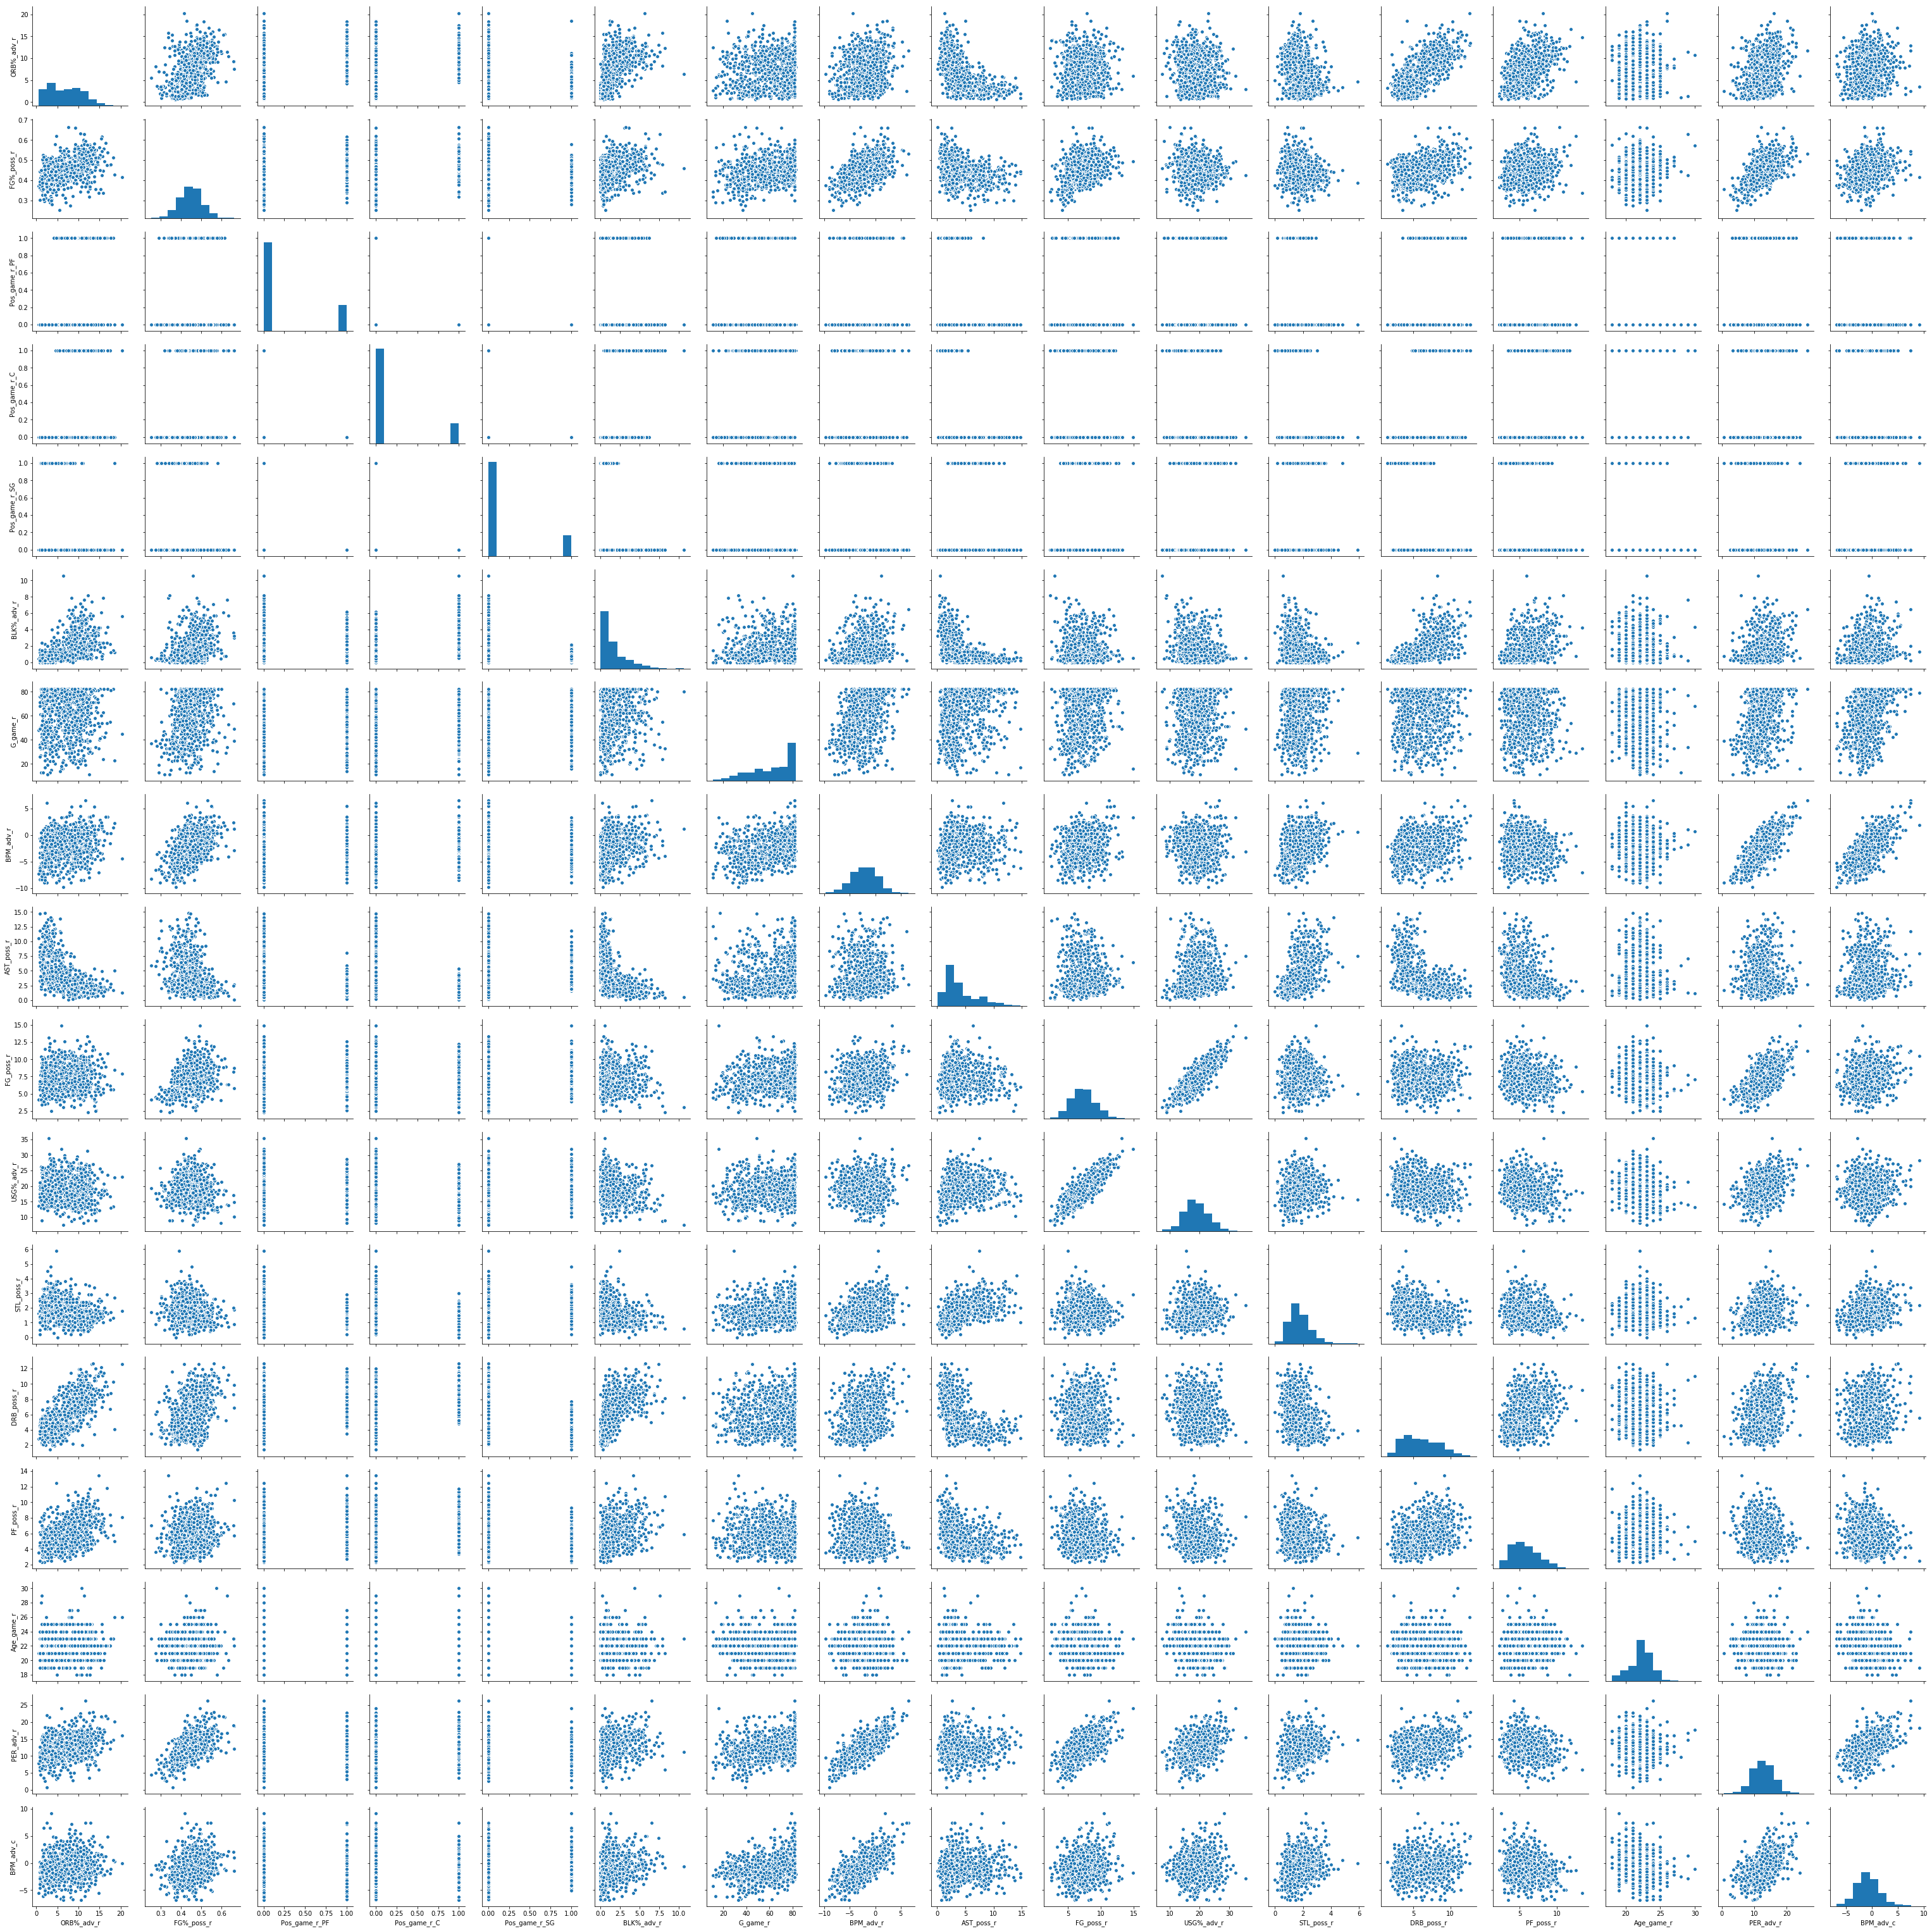

In [397]:
sns.pairplot(pd.concat([X_bpm[features_bpm_back], y_bpm],axis=1))

In [154]:
kf2 = KFold(n_splits=10, shuffle=True, random_state=2)

In [155]:
alphas = np.logspace(-11, -9, 50)
alpha_r2scores = []
for alpha in alphas:
    scores = []
    for train_ind, val_ind in kf2.split(X_ws,y_ws):
        X_train, y_train = X_ws[features_ws_back].values[train_ind], y_ws.values[train_ind]
        X_val, y_val = X_ws[features_ws_back].values[val_ind], y_ws.values[val_ind]
        
        std = StandardScaler()
        X_train_scaled = std.fit_transform(X_train)
        X_val_scaled = std.transform(X_val)
        
        lcv = Lasso(alpha=alpha)
        lcv.fit(X_train_scaled, y_train)
        scores.append(lcv.score(X_val_scaled, y_val))
    alpha_r2scores.append(np.mean(scores)) 

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

In [156]:
best_lasso_score = np.max(alpha_r2scores)
best_alpha = alphas[np.argmax(alpha_r2scores)]
print(best_lasso_score, best_alpha)

0.4150730370936063 1e-11


In [157]:
np.mean(cross_val_score(LinearRegression(), X_ws[features_ws_back], y_ws, cv=kf2))

0.41507325650363114

No regularization needed for model predicting WS/48.
Let's standardize the features anyway to compare coefficients to examine relative importance.

In [158]:
lm_ws_back = LinearRegression()
std_ws = StandardScaler()
X_ws_scaled = std_ws.fit_transform(X_ws[features_ws_back])
lm_ws_back.fit(X_ws_scaled, y_ws)

ws_df = pd.DataFrame(sorted(list(zip(features_ws_back, lm_ws_back.coef_)), key=lambda x: abs(x[1]), reverse=True))
ws_df['percentage'] = ws_df.iloc[:,1].apply(abs)
ws_df['percentage'] = 100*ws_df['percentage']/ws_df['percentage'].sum()
ws_df

,0,1,percentage
0,BLK%_adv_r,0.027879,15.644548
1,BLK_min_r,-0.022983,12.897150
2,DRB_min_r,0.022834,12.813378
3,AST_min_r,0.021081,11.829906
4,DRB%_adv_r,-0.017696,9.929905
5,AST%_adv_r,-0.017307,9.711923
6,WS/48_adv_r,0.012091,6.785043
7,BPM_adv_r,0.006676,3.746024
8,Age_game_r,-0.006492,3.642777
9,ORB%_adv_r,0.004614,2.589187


In [159]:
lm_ws_back.score(std_ws.transform(X_test_ws[features_ws_back]), y_test_ws)

0.39233843529878204

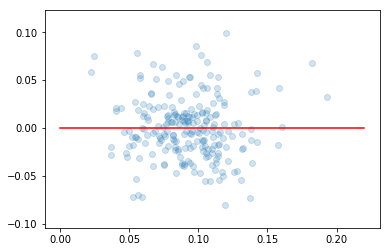

In [160]:
y_ws_pred = lm_ws_back.predict(std_ws.transform(X_test_ws[features_ws_back]))
plt.scatter(y_ws_pred, y_test_ws-y_ws_pred, alpha=.2)
plt.plot(np.linspace(0, .22, 2), np.zeros(2), c='r')

In [165]:
plt.hist(y_test_ws

SyntaxError: unexpected EOF while parsing (<ipython-input-165-306503bf907d>, line 1)

In [166]:
alphas = np.logspace(-5,-3,50)
alpha_r2scores = []
for alpha in alphas:
    scores = []
    for train_ind, val_ind in kf2.split(X_bpm,y_bpm):
        X_train, y_train = X_bpm[features_bpm_back].values[train_ind], y_bpm.values[train_ind]
        X_val, y_val = X_bpm[features_bpm_back].values[val_ind], y_bpm.values[val_ind]
        
        std = StandardScaler()
        X_train_scaled = std.fit_transform(X_train)
        X_val_scaled = std.transform(X_val)
        
        lcv = Lasso(alpha=alpha)
        lcv.fit(X_train_scaled, y_train)
        scores.append(lcv.score(X_val_scaled, y_val))
    alpha_r2scores.append(np.mean(scores))

In [167]:
best_lasso_score = np.max(alpha_r2scores)
best_alpha = alphas[np.argmax(alpha_r2scores)]
print(best_lasso_score, best_alpha)

0.5369116953541205 8.68511373751352e-05


In [168]:
lm_bpm_back = Lasso(alpha=best_alpha)
std_bpm = StandardScaler()
X_bpm_scaled = std_bpm.fit_transform(X_bpm[features_bpm_back])
lm_bpm_back.fit(X_bpm_scaled, y_bpm)
lm_bpm_back.coef_

bpm_df = pd.DataFrame(sorted(list(zip(features_bpm_back, lm_bpm_back.coef_)), key=lambda x: abs(x[1]), reverse=True))
bpm_df['percentage'] = bpm_df.iloc[:,1].apply(abs)
bpm_df['percentage'] = 100*bpm_df['percentage']/bpm_df['percentage'].sum()
bpm_df

,0,1,percentage
0,BPM_adv_r,1.582545,25.790239
1,USG%_adv_r,0.662442,10.795610
2,PER_adv_r,-0.490079,7.986666
3,FG_poss_r,-0.414593,6.756491
4,Age_game_r,-0.386486,6.298437
5,PF_poss_r,-0.377827,6.157327
6,BLK%_adv_r,0.365016,5.948558
7,DRB_poss_r,0.334600,5.452869
8,ORB%_adv_r,0.274567,4.474536
9,Pos_game_r_C,-0.263924,4.301088


In [169]:
lm_bpm_back.score(std_bpm.transform(X_test_bpm[features_bpm_back]), y_test_bpm)

0.5129056721128881

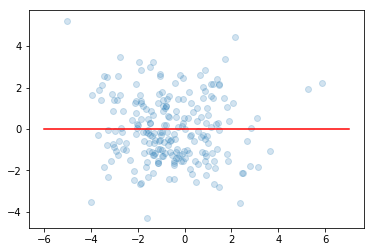

In [170]:
y_bpm_pred = lm_bpm_back.predict(std_bpm.transform(X_test_bpm[features_bpm_back]))
plt.scatter(y_bpm_pred, y_test_bpm-y_bpm_pred, alpha=.2)
plt.plot(np.linspace(-6, 7, 2), np.zeros(2), c='r')

In [171]:
def crossvalLasso(X, y,a,b,n,cv):
    alphas = np.logspace(a, b, n)
    alpha_r2scores = []
    for alpha in alphas:
        scores = []
        for train_ind, val_ind in cv.split(X,y):
            X_train, y_train = X.values[train_ind], y.values[train_ind]
            X_val, y_val = X.values[val_ind], y.values[val_ind]

            std = StandardScaler()
            X_train_scaled = std.fit_transform(X_train)
            X_val_scaled = std.transform(X_val)

            lcv = Lasso(alpha=alpha)
            lcv.fit(X_train_scaled, y_train)
            scores.append(lcv.score(X_val_scaled, y_val))
    alpha_r2scores.append(np.mean(scores))
    best_lasso_score = np.max(alpha_r2scores)

    best_alpha = alphas[np.argmax(alpha_r2scores)]
    return best_lasso_score, best_alpha

## Polynomial transforms

In [172]:
#let's try to poly transform 4 biggest features and examine significance of each term
poly_ws = PolynomialFeatures(degree=2)
top_4_ws_features = list(map(lambda y: y[0], sorted(list(zip(features_ws_back, lm_ws_back.coef_)), key=lambda x: abs(x[1]), reverse=True)))[:4]
X_poly_ws = poly_ws.fit_transform(X_ws[top_4_ws_features])

poly_bpm = PolynomialFeatures(degree=2)
top_4_bpm_features = list(map(lambda y: y[0], sorted(list(zip(features_bpm_back, lm_bpm_back.coef_)), key=lambda x: abs(x[1]), reverse=True)))[:4]
X_poly_bpm = poly_bpm.fit_transform(X_bpm[top_4_bpm_features])

In [173]:
poly_ws.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [174]:
sm.OLS(y_ws, sm.add_constant(X_poly_ws)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            WS/48_adv_c   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     11.22
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           5.70e-24
Time:                        21:41:10   Log-Likelihood:                 1689.6
No. Observations:                 896   AIC:                            -3349.
Df Residuals:                     881   BIC:                            -3277.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0669      0.018      3.725      0.000       0.032       0.102
x1            -0.0288      0.023     -1.276      0.202      -0.073       0.016
x2             0.0614      0.042      1.465      0.143      -0.021       0.144
x3            -0.0031      0.006     -0.491      0.624      -0.016       0.009
x4             0.0002      0.004      0.036      0.972      -0.009       0.009
x5            -0.0069      0.007     -0.937      0.349      -0.021       0.008
x6             0.0234      0.027      0.867      0.386      -0.030       0.077
x7             0.0099      0.003      3.201      0.001       0.004       0.016
x8            -0.0042      0.004     -0.939      0.348      -0.013       0.005
x9            -0.0207      0.025     -0.839      0.402      -0.069       0.028
x10           -0.0169      0.006     -2.893      0.004      -0.028      -0.005
x11            0.0069      0.008      0.858      0.391      -0.009       0.023
x12            0.0005      0.001      0.893      0.372      -0.001       0.002
x13            0.0017      0.001      2.122      0.034       0.000       0.003
x14           -0.0002      0.000     -0.520      0.603      -0.001       0.000
==============================================================================
Omnibus:                       34.170   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.595
Skew:                           0.359   Prob(JB):                     4.62e-11
Kurtosis:                       3.871   Cond. No.                     1.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [175]:
top_4_ws_features

['BLK%_adv_r', 'BLK_min_r', 'DRB_min_r', 'AST_min_r']

Let's add some interaction terms to our model and see if validation scores improve.  I will consider terms with p-values below .02.  For WS/48, we'll add BLK%\*DRB/min and BLK/min\*DRB/min.

In [176]:
features_ws_inter = features_ws_back + ['BLK%*DRB_min', 'BLK_min*DRB_min']
X_ws['BLK%*DRB_min'] = X_ws['BLK%_adv_r'] * X_ws['DRB_min_r']
X_ws['BLK_min*DRB_min'] = X_ws['BLK_min_r'] * X_ws['DRB_min_r']
X_test_ws['BLK%*DRB_min'] = X_test_ws['BLK%_adv_r'] * X_test_ws['DRB_min_r']
X_test_ws['BLK_min*DRB_min'] = X_test_ws['BLK_min_r'] * X_test_ws['DRB_min_r']

#compare this to model without interaction terms on same validation set
np.mean(cross_val_score(LinearRegression(), X_ws[features_ws_inter], y_ws, cv=kf2))

0.41862555740130186

In [178]:
crossvalLasso(X_ws[features_ws_inter], y_ws, -8, -6, 50, kf2)

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

(0.4196061456368634, 1e-08)

.415 for no interaction vs .419 for interactions, so let's include them in our final model for WS/48

In [198]:
lm_ws_inter = LinearRegression()
std_ws = StandardScaler()
X_ws_scaled = std_ws.fit_transform(X_ws[features_ws_inter])
lm_ws_inter.fit(X_ws_scaled, y_ws)

ws_df = pd.DataFrame(sorted(list(zip(features_ws_inter, lm_ws_inter.coef_)), key=lambda x: abs(x[1]), reverse=True))
ws_df['percentage'] = ws_df.iloc[:,1].apply(abs)
ws_df['percentage'] = 100*ws_df['percentage']/ws_df['percentage'].sum()
ws_df

,0,1,percentage
0,BLK%*DRB_min,0.095216,23.608818
1,BLK_min*DRB_min,-0.086016,21.327616
2,BLK%_adv_r,-0.056352,13.972533
3,BLK_min_r,0.052431,13.000328
4,DRB_min_r,0.019802,4.909808
5,DRB%_adv_r,-0.016755,4.154534
6,AST_min_r,0.016349,4.053627
7,AST%_adv_r,-0.013536,3.356219
8,WS/48_adv_r,0.010970,2.719980
9,BPM_adv_r,0.008070,2.001067


In [199]:
lm_ws_inter.score(std_ws.transform(X_test_ws[features_ws_inter]), y_test_ws)

0.38115646786290813

R^2 of final model to predict WS/48: 0.3811564678629079 

In [200]:
poly_bpm.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [201]:
sm.OLS(y_bpm, sm.add_constant(X_poly_bpm)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              BPM_adv_c   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     66.94
Date:                Fri, 12 Oct 2018   Prob (F-statistic):          4.94e-128
Time:                        01:08:04   Log-Likelihood:                -1683.3
No. Observations:                 896   AIC:                             3397.
Df Residuals:                     881   BIC:                             3468.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6411      1.792     -2.032      0.042      -7.159      -0.124
x1             0.8271      0.298      2.778      0.006       0.243       1.411
x2             0.7658      0.216      3.538      0.000       0.341       1.191
x3            -0.1881      0.283     -0.664      0.507      -0.744       0.368
x4            -0.5440      0.520     -1.046      0.296      -1.564       0.476
x5             0.0630      0.017      3.700      0.000       0.030       0.096
x6             0.0667      0.020      3.377      0.001       0.028       0.105
x7            -0.0743      0.028     -2.700      0.007      -0.128      -0.020
x8            -0.0249      0.048     -0.523      0.601      -0.118       0.069
x9             0.0001      0.010      0.012      0.990      -0.019       0.019
x10           -0.0582      0.017     -3.400      0.001      -0.092      -0.025
x11            0.0399      0.044      0.915      0.360      -0.046       0.125
x12            0.0354      0.015      2.379      0.018       0.006       0.065
x13            0.0256      0.049      0.527      0.598      -0.070       0.121
x14           -0.0605      0.062     -0.978      0.329      -0.182       0.061
==============================================================================
Omnibus:                       33.382   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.639
Skew:                           0.423   Prob(JB):                     4.07e-09
Kurtosis:                       3.565   Cond. No.                     1.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [202]:
top_4_bpm_features

['BPM_adv_r', 'USG%_adv_r', 'PER_adv_r', 'FG_poss_r']

Let's add some interaction terms to our model and see if validation scores improve.  I will consider terms with p-values below .02.  For BPM, we'll add BLK%^2, BPM\*USG%, BPM\*PER, USG%\*PER, PER^2.

In [203]:
features_bpm_inter = features_bpm_back + ['BLK%^2','BPM*USG%', 'BPM*PER', 'USG%*PER', 'PER^2']
X_bpm['BLK%^2'] = X_bpm['BLK%_adv_r']**2
X_bpm['BPM*USG%'] = X_bpm['BPM_adv_r'] * X_bpm['USG%_adv_r']
X_bpm['BPM*PER'] = X_bpm['BPM_adv_r'] * X_bpm['PER_adv_r']
X_bpm['USG%*PER'] = X_bpm['USG%_adv_r'] * X_bpm['PER_adv_r']
X_bpm['PER^2'] = X_bpm['PER_adv_r']**2

X_test_bpm['BLK%^2'] = X_test_bpm['BLK%_adv_r']**2
X_test_bpm['BPM*USG%'] = X_test_bpm['BPM_adv_r'] * X_test_bpm['USG%_adv_r']
X_test_bpm['BPM*PER'] = X_test_bpm['BPM_adv_r'] * X_test_bpm['PER_adv_r']
X_test_bpm['USG%*PER'] = X_test_bpm['USG%_adv_r'] * X_test_bpm['PER_adv_r']
X_test_bpm['PER^2'] = X_test_bpm['PER_adv_r']**2

#compare this to model without interaction terms on same validation set
np.mean(cross_val_score(LinearRegression(), X_bpm[features_bpm_inter], y_bpm, cv=kf2))

0.5403337709302192

In [204]:
crossvalLasso(X_bpm[features_bpm_inter], y_bpm, -14,-12, 50, kf2)

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/goodwin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

(0.5403406394839847, 1e-14)

We get slightly better results (.5403 vs .5369) using interaction terms (without regularization) than no interaction terms.  So let's include them in our final model for BPM.

In [205]:
lm_bpm_inter = LinearRegression()
std_bpm_ = StandardScaler()
X_bpm_scaled = std_bpm.fit_transform(X_bpm[features_bpm_inter])
lm_bpm_inter.fit(X_bpm_scaled, y_bpm)

bpm_df = pd.DataFrame(sorted(list(zip(features_bpm_inter, lm_bpm_inter.coef_)), key=lambda x: abs(x[1]), reverse=True))
bpm_df['percentage'] = bpm_df.iloc[:,1].apply(abs)
bpm_df['percentage'] = 100*bpm_df['percentage']/bpm_df['percentage'].sum()
bpm_df

,0,1,percentage
0,USG%*PER,-1.804781,19.799522
1,USG%_adv_r,1.709970,18.759390
2,BPM*USG%,0.989052,10.850489
3,PER^2,0.768855,8.434795
4,BPM_adv_r,0.542450,5.950995
5,FG_poss_r,-0.415104,4.553936
6,Age_game_r,-0.373126,4.093412
7,PF_poss_r,-0.330808,3.629163
8,DRB_poss_r,0.284806,3.124492
9,ORB%_adv_r,0.272354,2.987885


In [206]:
features_bpm_inter

['Pos_game_r_C',
 'ORB%_adv_r',
 'DRB_poss_r',
 'G_game_r',
 'FG_poss_r',
 'PER_adv_r',
 'AST_poss_r',
 'STL_poss_r',
 'FG%_poss_r',
 'USG%_adv_r',
 'PF_poss_r',
 'Age_game_r',
 'Pos_game_r_PF',
 'BLK%_adv_r',
 'BPM_adv_r',
 'Pos_game_r_SG',
 'BLK%^2',
 'BPM*USG%',
 'BPM*PER',
 'USG%*PER',
 'PER^2']

In [207]:
lm_bpm_inter.score(std_bpm.transform(X_test_bpm[features_bpm_inter]), y_test_bpm)

0.5031912211418127

R^2 of final model to predict BPM: 0.5031912211418127

In [208]:
sm.OLS(y_ws, sm.add_constant(X_ws[features_ws_inter])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            WS/48_adv_c   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     41.47
Date:                Fri, 12 Oct 2018   Prob (F-statistic):          3.93e-104
Time:                        01:08:16   Log-Likelihood:                 1892.0
No. Observations:                 896   AIC:                            -3746.
Df Residuals:                     877   BIC:                            -3655.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1397      0.021      6.706      0.000       0.099       0.181
ORB%_adv_r          0.0010      0.001      2.061      0.040    4.94e-05       0.002
Pos_game_r_PG       0.0063      0.005      1.307      0.192      -0.003       0.016
DRB_min_r           0.0117      0.005      2.267      0.024       0.002       0.022
WS/48_adv_r         0.2113      0.040      5.229      0.000       0.132       0.291
AST_min_r           0.0078      0.003      2.733      0.006       0.002       0.013
BLK_min_r           0.0636      0.027      2.330      0.020       0.010       0.117
FT%_min_r           0.0209      0.012      1.706      0.088      -0.003       0.045
DRB%_adv_r         -0.0031      0.002     -1.923      0.055      -0.006    6.49e-05
AST%_adv_r         -0.0016      0.001     -2.204      0.028      -0.003      -0.000
PF_min_r           -0.0028      0.001     -2.752      0.006      -0.005      -0.001
Age_game_r         -0.0045      0.001     -6.515      0.000      -0.006      -0.003
FT_min_r            0.0034      0.001      3.239      0.001       0.001       0.005
BLK%_adv_r         -0.0361      0.014     -2.552      0.011      -0.064      -0.008
BPM_adv_r           0.0031      0.001      3.440      0.001       0.001       0.005
MP_game_r           0.0004      0.000      1.849      0.065   -2.17e-05       0.001
Pos_game_r_SG       0.0044      0.004      1.203      0.229      -0.003       0.012
BLK%*DRB_min        0.0092      0.002      4.031      0.000       0.005       0.014
BLK_min*DRB_min    -0.0154      0.004     -3.560      0.000      -0.024      -0.007
==============================================================================
Omnibus:                       59.084   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.495
Skew:                           0.584   Prob(JB):                     4.04e-17
Kurtosis:                       3.812   Cond. No.                     1.55e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [223]:
sm.OLS(y_bpm, sm.add_constant(X_bpm[features_bpm_inter])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              BPM_adv_c   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     56.54
Date:                Fri, 12 Oct 2018   Prob (F-statistic):          9.08e-147
Time:                        01:18:20   Log-Likelihood:                -1623.4
No. Observations:                 896   AIC:                             3291.
Df Residuals:                     874   BIC:                             3396.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1499      1.824      0.082      0.935      -3.430       3.730
Pos_game_r_C     -0.7107      0.225     -3.153      0.002      -1.153      -0.268
ORB%_adv_r        0.0700      0.025      2.822      0.005       0.021       0.119
DRB_poss_r        0.1211      0.041      2.934      0.003       0.040       0.202
G_game_r          0.0120      0.003      3.728      0.000       0.006       0.018
FG_poss_r        -0.2249      0.101     -2.221      0.027      -0.424      -0.026
PER_adv_r        -0.0008      0.192     -0.004      0.997      -0.377       0.375
AST_poss_r        0.0466      0.032      1.459      0.145      -0.016       0.109
STL_poss_r        0.1913      0.100      1.917      0.056      -0.005       0.387
FG%_poss_r        1.8861      1.836      1.028      0.304      -1.717       5.489
USG%_adv_r        0.4279      0.103      4.165      0.000       0.226       0.630
PF_poss_r        -0.1806      0.041     -4.430      0.000      -0.261      -0.101
Age_game_r       -0.2482      0.035     -7.078      0.000      -0.317      -0.179
Pos_game_r_PF    -0.5057      0.186     -2.712      0.007      -0.872      -0.140
BLK%_adv_r        0.0917      0.117      0.786      0.432      -0.137       0.321
BPM_adv_r         0.2081      0.169      1.230      0.219      -0.124       0.540
Pos_game_r_SG     0.2323      0.151      1.541      0.124      -0.064       0.528
BLK%^2            0.0201      0.016      1.265      0.206      -0.011       0.051
BPM*USG%          0.0186      0.007      2.596      0.010       0.005       0.033
BPM*PER           0.0035      0.011      0.305      0.761      -0.019       0.026
USG%*PER         -0.0179      0.006     -2.849      0.004      -0.030      -0.006
PER^2             0.0087      0.008      1.054      0.292      -0.007       0.025
==============================================================================
Omnibus:                       25.764   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.195
Skew:                           0.379   Prob(JB):                     7.54e-07
Kurtosis:                       3.424   Cond. No.                     1.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

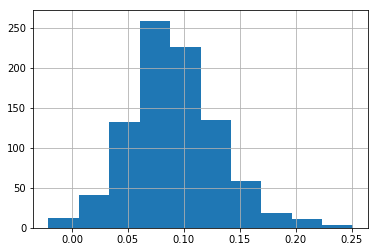

In [209]:
y_ws.hist()

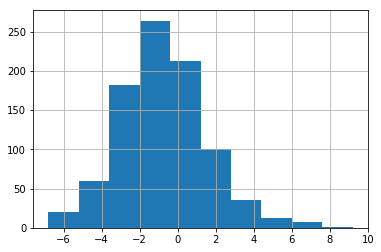

In [210]:
y_bpm.hist()

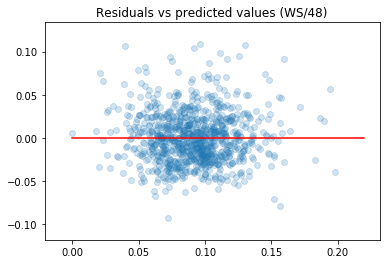

In [230]:
y_ws_pred = lm_ws_inter.predict(std_ws.transform(X_ws[features_ws_inter]))
plt.scatter(y_ws_pred, y_ws-y_ws_pred, alpha=.2)
plt.plot(np.linspace(0, .22, 2), np.zeros(2), c='r')
plt.title('Residuals vs predicted values (WS/48)')
plt.savefig('residual_ws.png')

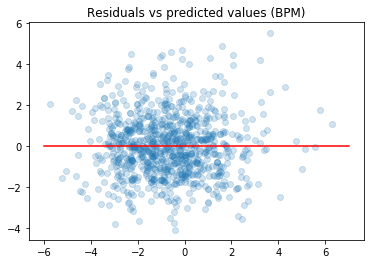

In [231]:
y_bpm_pred = lm_bpm_inter.predict(std_bpm.transform(X_bpm[features_bpm_inter]))
plt.scatter(y_bpm_pred, y_bpm-y_bpm_pred, alpha=.2)
plt.plot(np.linspace(-6, 7, 2), np.zeros(2), c='r')
plt.title('Residuals vs predicted values (BPM)')
plt.savefig('residual_bpm.png')

(array([  2.,   9.,  98., 216., 259., 178.,  77.,  35.,  12.,  10.]),
 array([-0.09292708, -0.07278148, -0.05263588, -0.03249028, -0.01234468,
         0.00780092,  0.02794652,  0.04809212,  0.06823772,  0.08838332,
         0.10852892]),
 <a list of 10 Patch objects>)

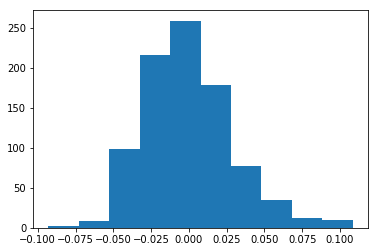

In [220]:
plt.hist(y_ws-y_ws_pred)

(array([  9.,  43., 143., 209., 237., 144.,  72.,  23.,  13.,   3.]),
 array([-4.07476352, -3.11368862, -2.15261372, -1.19153883, -0.23046393,
         0.73061097,  1.69168586,  2.65276076,  3.61383565,  4.57491055,
         5.53598545]),
 <a list of 10 Patch objects>)

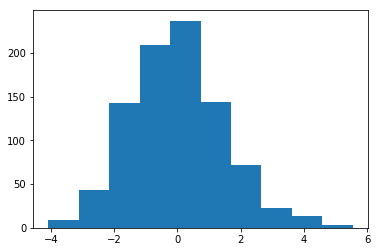

In [221]:
plt.hist(y_bpm-y_bpm_pred)

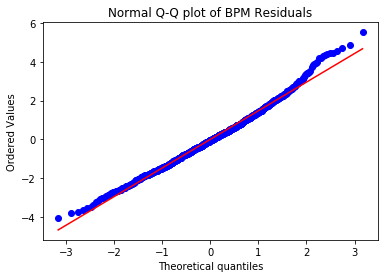

In [236]:
from scipy import stats
stats.probplot(y_bpm-y_bpm_pred, dist="norm", plot=plt)
plt.title("Normal Q-Q plot of BPM Residuals")
plt.savefig('qqplot_bpm.png')

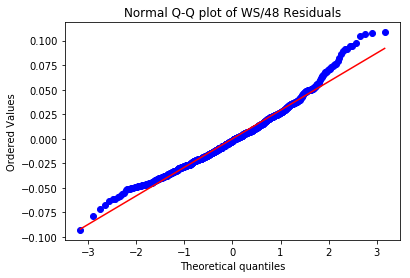

In [235]:
stats.probplot(y_ws-y_ws_pred, dist="norm", plot=plt)
plt.title("Normal Q-Q plot of WS/48 Residuals")
plt.savefig('qqplot_ws.png')

In [237]:
y_ws.mean()

0.09126562499999992

In [238]:
y_bpm.mean()

-0.7127232142857146

In [239]:
y_bpm.describe()

count    896.000000
mean      -0.712723
std        2.276260
min       -6.800000
25%       -2.200000
50%       -0.800000
75%        0.600000
max        9.200000
Name: BPM_adv_c, dtype: float64

In [240]:
y_test_ws.mean()

0.0924266666666666

In [241]:
y_test_bpm.mean()

-0.6208888888888893

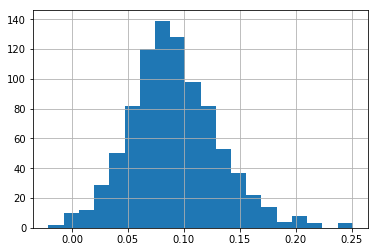

In [244]:
y_ws.hist(bins=20)

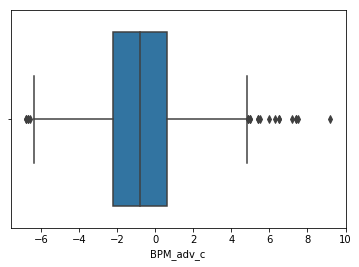

/home/goodwin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


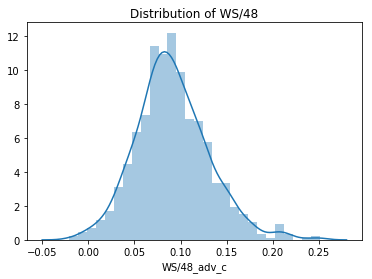

In [261]:
a = sns.distplot(y_ws)
plt.title('Distribution of WS/48')
a.get_figure().savefig('distplot_ws.png')
# .save_fig('distplot_ws.png')


/home/goodwin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


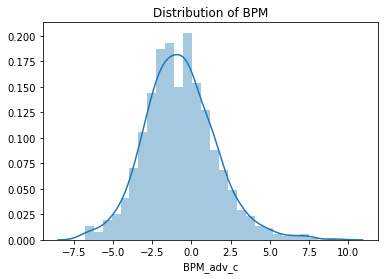

In [262]:
a =sns.distplot(y_bpm)
plt.title('Distribution of BPM')
a.get_figure().savefig('distplot_bpm.png')